In [10]:
import os
import cv2

import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D, ReLU, LeakyReLU, Softmax

from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imghdr

import imagesize
from PIL import Image

%config Completer.use_jedi = False

In [11]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                             rotation_range=45,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.25,
                                             horizontal_flip=True,
                                             fill_mode='nearest')

data_generator = ImageDataGenerator(rescale=1./255)


train_data = train_data_generator.flow_from_directory('images_v2_for_data_augmentation\\train',
                                                          class_mode='sparse',
                                                          batch_size=16,
                                                          target_size=(256, 256))
validation_data = data_generator.flow_from_directory('images_v2_for_data_augmentation\\validation',
                                                               class_mode='sparse',
                                                               batch_size=16,
                                                               target_size=(256, 256))

test_data = data_generator.flow_from_directory('images_v2_for_data_augmentation\\test',
                           target_size=(256, 256),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')

Found 11263 images belonging to 3 classes.
Found 3214 images belonging to 3 classes.
Found 1616 images belonging to 3 classes.


In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), 1, input_shape=(256,256,3), padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(Conv2D(32, (3, 3), 1, padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPooling2D(strides=2))

model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPooling2D(strides=2))

model.add(Conv2D(128, (3, 3), 1, padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(Conv2D(128, (3, 3), 1, padding='same'))
model.add(LeakyReLU(alpha=0.3))

model.add(MaxPooling2D(strides=2))

model.add(Flatten())
model.add(Dense(128))
model.add(ReLU())

model.add(Dropout(0.3))

model.add(Dense(128))
model.add(ReLU())

model.add(Dropout(0.3))

model.add(Dense(16))
model.add(ReLU())

model.add(Dense(3))
model.add(Softmax())

In [4]:
class LearningRateReducer(tf.keras.callbacks.Callback):
    def on_epoch_end(self, logs=None):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 0.98
        print(f"\nReducing Learning Rate from {old_lr} to {new_lr}")
        self.model.optimizer.lr.assign(new_lr)

In [5]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
log_directory = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [9]:
import datetime
now = datetime.datetime.now()
formatted_date = str("{}-{}-{}-{}-{}-{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second))
model_checkpoint = ModelCheckpoint('saved_models\\with_augmented_data\\v6-vgg19-inspired-'+ formatted_date + '.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_data,
                              steps_per_epoch=len(train_data),
                              epochs=5,
                              validation_data=validation_data,
                              validation_steps=len(validation_data),
                              callbacks=[tensorboard_callback, early_stopping, model_checkpoint])

Epoch 1/5
 16/704 [..............................] - ETA: 15:51 - loss: 1.2018 - accuracy: 0.3242

In [2]:
from keras import models

In [8]:
model = models.load_model('saved_models/with_augmented_data/v6-vgg19ish2023-2-22-19-24-57.h5', compile=False)

In [17]:
model.compile()

In [5]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'LeakyReLU',
   'config': {'name': 'leaky_re_lu',
    'trainable': True,
    'dt

In [18]:
predictions = model.predict(x=test_data, steps=len(test_data), verbose=0)

In [19]:
print(model.evaluate(x=test_data))

101/101 [==============================] - 18s 175ms/step - loss: 0.0000e+00
0.0


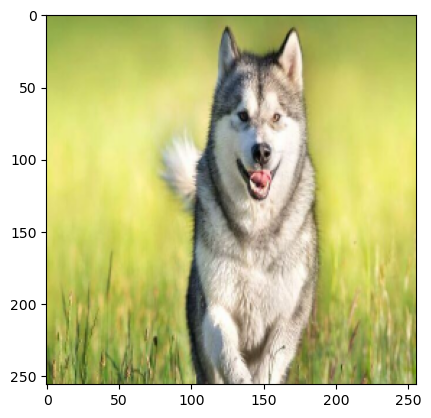

In [30]:
test_image = cv2.imread('test_images/01.png')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
resized_image = tf.image.resize(test_image, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [31]:
yhat = model.predict(np.expand_dims(resized_image / 255, 0))

In [32]:
yhat_list = yhat.tolist()[0]
print(yhat_list)
print("Prediction: category {}. Possibility: {}".format(yhat_list.index(max(yhat_list)), round(max(yhat_list), ndigits=4)))

[0.3407703936100006, 0.32968395948410034, 0.32954561710357666]
Prediction: category 0. Possibility: 0.3408


In [20]:
model = models.load_model('saved_models/with_augmented_data/v6-vgg19ish2023-2-22-19-24-57.h5', compile=False)

In [21]:
from sklearn.metrics import confusion_matrix   
y_prediction = model.predict(test_data)
y_prediction_argmax = np.argmax(y_prediction, axis=1)

In [26]:
y_prediction

array([[0.3407704 , 0.32968396, 0.32954562],
       [0.3407704 , 0.32968396, 0.32954562],
       [0.3407704 , 0.32968396, 0.32954562],
       ...,
       [0.3407704 , 0.32968396, 0.32954562],
       [0.3407704 , 0.32968396, 0.32954562],
       [0.3407704 , 0.32968396, 0.32954562]], dtype=float32)

In [22]:
result = confusion_matrix(test_data.classes, y_prediction_argmax)

<AxesSubplot:>

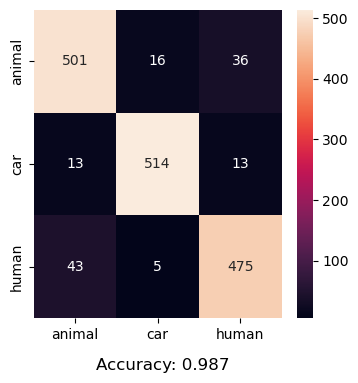

In [25]:
import seaborn as sn
dataframe_cm = pd.DataFrame(result, index = [label for label in ["animal", "car", "human"]],
                  columns = [label for label in ["animal", "car", "human"]])
plt.figure(figsize = (4,4))
plt.figtext(0.28, -0.02, "Accuracy: 0.987", fontsize=12)
sn.heatmap(dataframe_cm, annot=True, fmt='g')